In [1]:
from pprint import pprint
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import spikeinterface as si  # import core only
import spikeinterface.comparison as sc
import spikeinterface.curation as scur
import spikeinterface.exporters as sexp
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as sqm
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
from probeinterface.plotting import plot_probe
from probeinterface import get_probe
import numpy as np
from probeinterface import Probe

In [2]:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

# load the config file
config = ss.Kilosort4Sorter.default_params()

In [3]:
# print the config file
print("Defaults:\n")
pprint(config)

session_folder= Path('/snel/share/data/rodent-ephys/open-ephys/treadmill/sean-pipeline/godzilla/siemu_test/2022-11-17_17-08-07')
config.update(
{'Th_learned': 8,
 'Th_single_ch': 6,
 'Th_universal': 9,
 'acg_threshold': 0.2,
 'artifact_threshold': None,
 'batch_size': 60000,
 'binning_depth': 5,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'dmin': None,
 'dminx': 32,
 'do_CAR': True,
 'do_correction': True,
 'duplicate_spike_bins': 15,
 'invert_sign': False,
 'keep_good_only': False,
 'min_template_size': 10,
 'n_pcs': 6,
 'n_templates': 6,
 'nblocks': 0,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'nskip': 25,
 'nt': 61,
 'nt0min': None,
 'save_extra_kwargs': False,
 'scaleproc': None,
 'sig_interp': 20,
 'skip_kilosort_preprocessing': False,
 'template_sizes': 5,
 'templates_from_data': True,
 'torch_device': 'auto',
 'whitening_range': 32}
)
print("\nUpdated Config:\n")
pprint(config)

Defaults:

{'Th_learned': 8,
 'Th_single_ch': 6,
 'Th_universal': 9,
 'acg_threshold': 0.2,
 'artifact_threshold': None,
 'batch_size': 60000,
 'binning_depth': 5,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'dmin': None,
 'dminx': 32,
 'do_CAR': True,
 'do_correction': True,
 'duplicate_spike_bins': 15,
 'invert_sign': False,
 'keep_good_only': False,
 'min_template_size': 10,
 'n_pcs': 6,
 'n_templates': 6,
 'nblocks': 1,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'nskip': 25,
 'nt': 61,
 'nt0min': None,
 'save_extra_kwargs': False,
 'scaleproc': None,
 'sig_interp': 20,
 'skip_kilosort_preprocessing': False,
 'template_sizes': 5,
 'templates_from_data': True,
 'torch_device': 'auto',
 'whitening_range': 32}

Updated Config:

{'Th_learned': 8,
 'Th_single_ch': 6,
 'Th_universal': 9,
 'acg_threshold': 0.2,
 'artifact_threshold': None,
 'batch_size': 60000,
 'binning_depth': 5,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,

In [4]:
recording = se.read_openephys(session_folder)
print(recording)
keep_channels_iter = np.arange(0, 24)
print(type(recording))
recording = recording.channel_slice(recording.get_channel_ids()[keep_channels_iter])
# recording = recording.remove_channels(list(range(16,24)))
print(recording)
type(recording)

OpenEphysBinaryRecordingExtractor: 24 channels - 30.0kHz - 6 segments - 13,223,680 samples 
                                   440.79s (7.35 minutes) - int16 dtype - 605.33 MiB
Segments:
Samples:   2,282,752 | 2,690,304 | 3,058,432 | 1,212,416 | 1,662,464 | 2,317,312
Durations: 76.09s (1.27 minutes) | 89.68s (1.49 minutes) | 101.95s (1.70 minutes) | 40.41s | 55.42s | 77.24s (1.29 minutes)
Memory:    104.50 MiB | 123.15 MiB | 140.00 MiB | 55.50 MiB | 76.10 MiB | 106.08 MiB
<class 'spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor'>
ChannelSliceRecording: 24 channels - 30.0kHz - 6 segments - 13,223,680 samples 
                       440.79s (7.35 minutes) - int16 dtype - 605.33 MiB
Segments:
Samples:   2,282,752 | 2,690,304 | 3,058,432 | 1,212,416 | 1,662,464 | 2,317,312
Durations: 76.09s (1.27 minutes) | 89.68s (1.49 minutes) | 101.95s (1.70 minutes) | 40.41s | 55.42s | 77.24s (1.29 minutes)
Memory:    104.50 MiB | 123.15 MiB | 140.00 MiB | 55.50 MiB |

spikeinterface.core.channelslice.ChannelSliceRecording

Probe - 16ch - 1shanks
[[  0.  -0.]
 [  0.  -2.]
 [  0.  -4.]
 [  0.  -6.]
 [  0.  -8.]
 [  0. -10.]
 [  0. -12.]
 [  0. -14.]
 [  0. -16.]
 [  0. -18.]
 [  0. -20.]
 [  0. -22.]
 [  0. -24.]
 [  0. -26.]
 [  0. -28.]
 [  0. -30.]]


(<matplotlib.collections.PolyCollection at 0x7fe0eb18e750>, None)

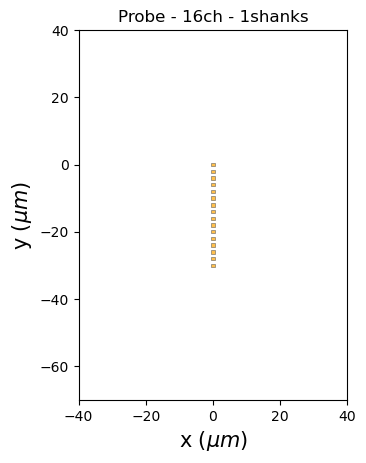

In [5]:
n = 16
positions = np.zeros((n, 2))
for i in range(n):
    x = 0
    y = i
    positions[i] = x, y
positions[:,1] *= -2

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='square', shape_params={'width': 1})
probe.device_channel_indices = np.array([9,10,11,12,5,6,7,8,1,2,3,4,13,14,15,16])-1

print(probe)
print(positions)
plot_probe(probe)

In [6]:
# set probe for recording
recording = recording.set_probe(probe)
print(probe.get_contact_count())

16


Channel ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16']
Sampling frequency: 30000.0
Number of channels: 16
Number of segments: 6


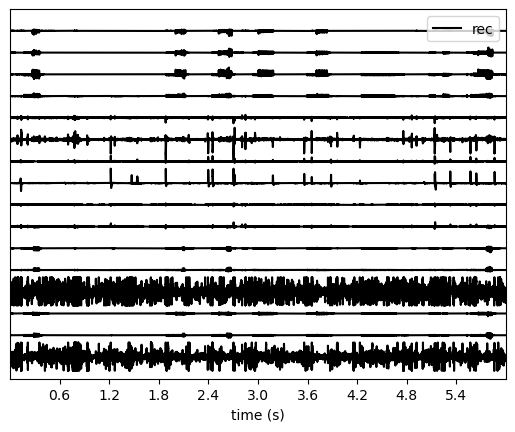

In [7]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print("Channel ids:", channel_ids)
print("Sampling frequency:", fs)
print("Number of channels:", num_chan)
print("Number of segments:", num_seg)

w_ts = sw.plot_traces(recording, time_range=(0, 6), segment_index=0)

In [8]:
recording_proc = recording
recording_proc = spre.bandpass_filter(recording_proc, freq_min=300, freq_max=5000)
# detect bad channels on filtered recording
bad_channel_ids, channel_labels = spre.detect_bad_channels(recording_proc, method='mad')#n_neighbors=int(3))
print("Bad Channels:\n"+str(bad_channel_ids))
recording_proc = recording_proc.remove_channels(remove_channel_ids=bad_channel_ids)
print(recording_proc)

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_proc.save(format="binary")
print(recording_preprocessed)

Bad Channels:
['CH1' 'CH4']
ChannelSliceRecording: 14 channels - 30.0kHz - 6 segments - 13,223,680 samples 
                       440.79s (7.35 minutes) - int16 dtype - 353.11 MiB
Segments:
Samples:   2,282,752 | 2,690,304 | 3,058,432 | 1,212,416 | 1,662,464 | 2,317,312
Durations: 76.09s (1.27 minutes) | 89.68s (1.49 minutes) | 101.95s (1.70 minutes) | 40.41s | 55.42s | 77.24s (1.29 minutes)
Memory:    60.96 MiB | 71.84 MiB | 81.67 MiB | 32.38 MiB | 44.39 MiB | 61.88 MiB
Use cache_folder=/tmp/spikeinterface_cache/tmpyx2zzy9j/WCA5PZ0R
write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/444 [00:00<?, ?it/s]

BinaryFolderRecording: 14 channels - 30.0kHz - 6 segments - 13,223,680 samples 
                       440.79s (7.35 minutes) - int16 dtype - 353.11 MiB
Segments:
Samples:   2,282,752 | 2,690,304 | 3,058,432 | 1,212,416 | 1,662,464 | 2,317,312
Durations: 76.09s (1.27 minutes) | 89.68s (1.49 minutes) | 101.95s (1.70 minutes) | 40.41s | 55.42s | 77.24s (1.29 minutes)
Memory:    60.96 MiB | 71.84 MiB | 81.67 MiB | 32.38 MiB | 44.39 MiB | 61.88 MiB


In [9]:
# put each recording into a list
rec_list = []
print(f"selecting {recording_preprocessed.get_num_segments()} segments")
for iRec in range(recording_preprocessed.get_num_segments()):
    print(iRec)
    rec_list.append(recording_preprocessed.select_segments([iRec]))
    
rec_list
    
 


selecting 6 segments
0
1
2
3
4
5


[SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 2,282,752 samples 
                         76.09s (1.27 minutes) - int16 dtype - 60.96 MiB,
 SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 2,690,304 samples 
                         89.68s (1.49 minutes) - int16 dtype - 71.84 MiB,
 SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 3,058,432 samples 
                         101.95s (1.70 minutes) - int16 dtype - 81.67 MiB,
 SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 1,212,416 samples - 40.41s 
                         int16 dtype - 32.38 MiB,
 SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 1,662,464 samples - 55.42s 
                         int16 dtype - 44.39 MiB,
 SelectSegmentRecording: 14 channels - 30.0kHz - 1 segments - 2,317,312 samples 
                         77.24s (1.29 minutes) - int16 dtype - 61.88 MiB]

In [10]:
# recording concatenation
recording_concatenated = si.concatenate_recordings(rec_list)
type(recording_concatenated)

spikeinterface.core.segmentutils.ConcatenateSegmentRecording

In [11]:
session_folder

PosixPath('/snel/share/data/rodent-ephys/open-ephys/treadmill/sean-pipeline/godzilla/siemu_test/2022-11-17_17-08-07')

In [13]:
# save the concatenated recording
recording_concatenated.save(format="binary", folder=session_folder / "concatenated_data")

write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/441 [00:00<?, ?it/s]

BinaryFolderRecording: 14 channels - 30.0kHz - 1 segments - 13,223,680 samples 
                       440.79s (7.35 minutes) - int16 dtype - 353.11 MiB

In [17]:
# check if the concatenated recording exists, and if so, load it
concat_exist = Path.exists(session_folder / "concatenated_data")
if concat_exist:
    recording_concatenated = si.load_extractor(session_folder / "concatenated_data")

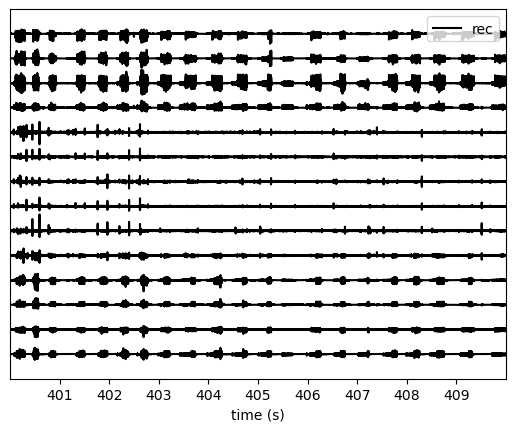

In [18]:
w_cat = sw.plot_traces(recording_concatenated, time_range=(400, 410), segment_index=0)

In [12]:
print("Available sorters", ss.available_sorters())
print("Installed sorters", ss.installed_sorters())


Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['kilosort4', 'spykingcircus2', 'tridesclous', 'tridesclous2']


In [27]:
working_folder=session_folder.joinpath('sorted0')
# pprint(config)
if working_folder.exists():
    shutil.rmtree(working_folder, ignore_errors=True)
sorting_KS4 = ss.run_sorter(sorter_name="kilosort4",recording=recording_concatenated, output_folder=working_folder, **config)

Loading recording with SpikeInterface...
number of samples: 13223680
number of channels: 14
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  0.05s; total  0.05s

computing drift
nblocks = 0, skipping drift correction
drift computed in  0.00s; total  0.05s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 221/221 [00:04<00:00, 55.19it/s]


35691 spikes extracted in  4.15s; total  4.20s

First clustering


100%|██████████| 8/8 [00:01<00:00,  4.29it/s]


53 clusters found, in  1.92s; total  6.12s

Extracting spikes using cluster waveforms


100%|██████████| 221/221 [00:14<00:00, 15.42it/s]


226697 spikes extracted in  14.40s; total  20.51s

Final clustering


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


35 clusters found, in  5.18s; total  25.70s

Merging clusters
35 units found, in  0.30s; total  25.99s

Saving to phy and computing refractory periods
2 units found with good refractory periods

Total runtime: 27.04s = 00:00:27 h:m:s


/home/sean/micromamba/envs/siemu/lib/python3.11/site-packages/spikeinterface/core/basesorting.py:175: UserWarning: Some spikes exceed the recording's duration! Removing these excess spikes with `spikeinterface.curation.remove_excess_spikes()` Might be necessary for further postprocessing.
  warnings.warn(
